In [41]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np

# Function to extract B-factors (which are pLDDT scores in AlphaFold models) from a PDB file
def extractBFactor(pdbFile, chainID):
    patternATOM = re.compile(
        r'^ATOM\s+'
        r'\d+\s+'
        r'CA\s+'
        r'([A-Z]{3})\s+'
        + re.escape(chainID) +
        r'\s?(\d+)\s+'
        r'[-+]?\d*\.\d+\s+'
        r'[-+]?\d*\.\d+\s+'
        r'[-+]?\d*\.\d+\s+'
        r'\d*\.\d+\s+'
        r'(\d+\.\d+)'
    )
    bFactors = {}

    with open(pdbFile, 'r') as file:
        for line in file:
            if line.startswith("ATOM") and " CA " in line:
                atomInfo = re.search(patternATOM, line)
                if atomInfo:
                    resName = atomInfo.group(1)
                    resNumber = int(atomInfo.group(2))
                    bFactor = float(atomInfo.group(3))
                    bFactors[resName + ' ' + str(resNumber)] = bFactor

    return bFactors

# Function to calculate the average pLDDT from the extracted B-factors
def calculate_average_plddt(bFactors):
    if not bFactors:
        return None
    return sum(bFactors.values()) / len(bFactors)

# Function to get the rNUMBER from the filename
def extract_rNumber(filename):
    pattern = re.compile(r'_r(\d+)_')
    match = pattern.search(filename)
    if match:
        return int(match.group(1))
    return None

# Define the color palette for rNUMBER
colors = [
    '#ea96a3',  # Recycle 0
    '#e39361',  # Recycle 1
    '#be9b4a',  # Recycle 2
    '#9fa046',  # Recycle 3
    '#7aaa48',  # Recycle 4
    '#48af79',  # Recycle 5
    '#4aac99',  # Recycle 6
    '#4dabae',  # Recycle 7
    '#53acc9',  # Recycle 8
    '#8eaee7',  # Recycle 9
    '#bfa3ea',  # Recycle 10
    '#e689e6',  # Recycle 11
    '#e891c3'   # Recycle 12
]

# Function to process all PDB files in a folder
def process_pdb_files(folder, chainID):
    data = []
    for filename in os.listdir(folder):
        if filename.endswith(".pdb") or filename.endswith(".cif"):
            pdbFile = os.path.join(folder, filename)
            bFactors = extractBFactor(pdbFile, chainID)
            avg_plddt = calculate_average_plddt(bFactors)
            rNumber = extract_rNumber(filename)
            if rNumber is not None and avg_plddt is not None:
                data.append((rNumber, avg_plddt))
    return data

# Function to plot a stacked histogram with overall distribution line
def plot_stacked_histogram_with_line(data, bins=25):
    # Separate pLDDT values by rNUMBER
    rNumbers = [item[0] for item in data]
    avg_plddt_values = [item[1] for item in data]

    # Create an array to store the counts per bin, per rNUMBER
    bin_edges = np.linspace(min(avg_plddt_values), max(avg_plddt_values), bins+1)
    bin_counts = np.zeros((len(colors), bins))  # Rows correspond to rNUMBERS, columns to bins

    # Count the occurrences of each rNUMBER in each bin
    for rNumber, plddt_value in zip(rNumbers, avg_plddt_values):
        bin_index = np.digitize(plddt_value, bin_edges) - 1  # Get the bin index for the value
        bin_index = np.clip(bin_index, 0, bins-1)  # Ensure the bin index stays within bounds
        bin_counts[rNumber % len(colors), bin_index] += 1  # Add to the corresponding rNUMBER

    # Plot the stacked bar chart with absolute counts
    fig, ax = plt.subplots(figsize=(10, 6))

    cumulative_counts = np.zeros(bins)  # Track the cumulative count for stacking

    # Stack the bars for each rNUMBER
    for i, color in enumerate(colors):
        ax.bar(bin_edges[:-1], bin_counts[i], width=np.diff(bin_edges), bottom=cumulative_counts, color=color, edgecolor='white', label=f'r{i}')
        cumulative_counts += bin_counts[i]

    # Add a line plot showing the total number of models per bin
    total_counts = np.sum(bin_counts, axis=0)
    ax.plot(bin_edges[:-1], total_counts, color='black', marker='o', linestyle='-', label='Total count')

    plt.title('pLDDT Distribution by recycle | Subsampled (256-512) partial hCav1.2 α subunit ', fontsize=15)
    plt.xlabel('Average pLDDT', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.legend(title='Recycle number')
    plt.show()



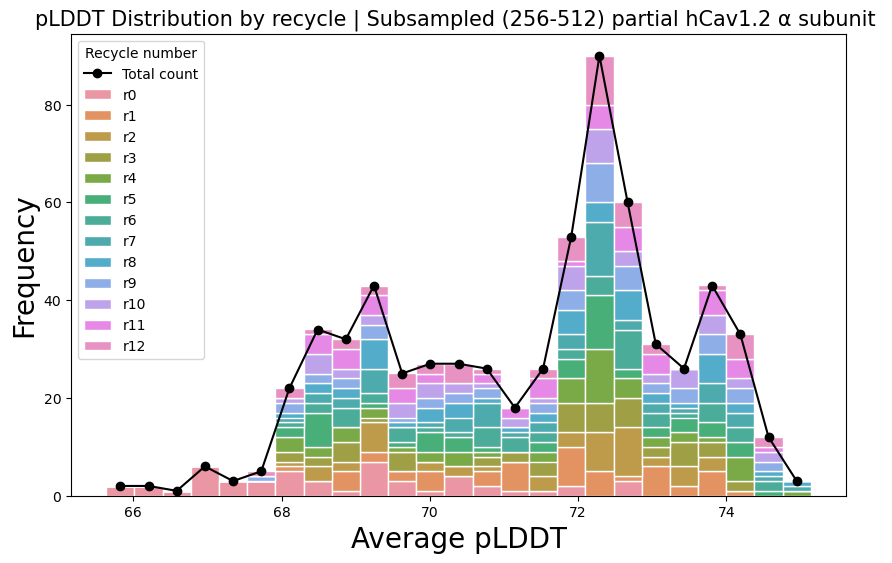

In [42]:

# Example usage
folder_path = "/Users/adrianahernandezgonzalez/LabNotebook/10-24/states/partialAlphaCaV12HS8HLPlocalrun_b3702_256_512_10/pdb/"  # Specify your folder containing PDB files
chainID = "A"  # Replace with your desired chain ID

data = process_pdb_files(folder_path, chainID)
plot_stacked_histogram_with_line(data)
